# Optical Flow
## Sparse Optical Flow

As always start by importing the relevant packages.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load the images `OF1.jpg` and `OF2.jpg` and change them to grayscale.

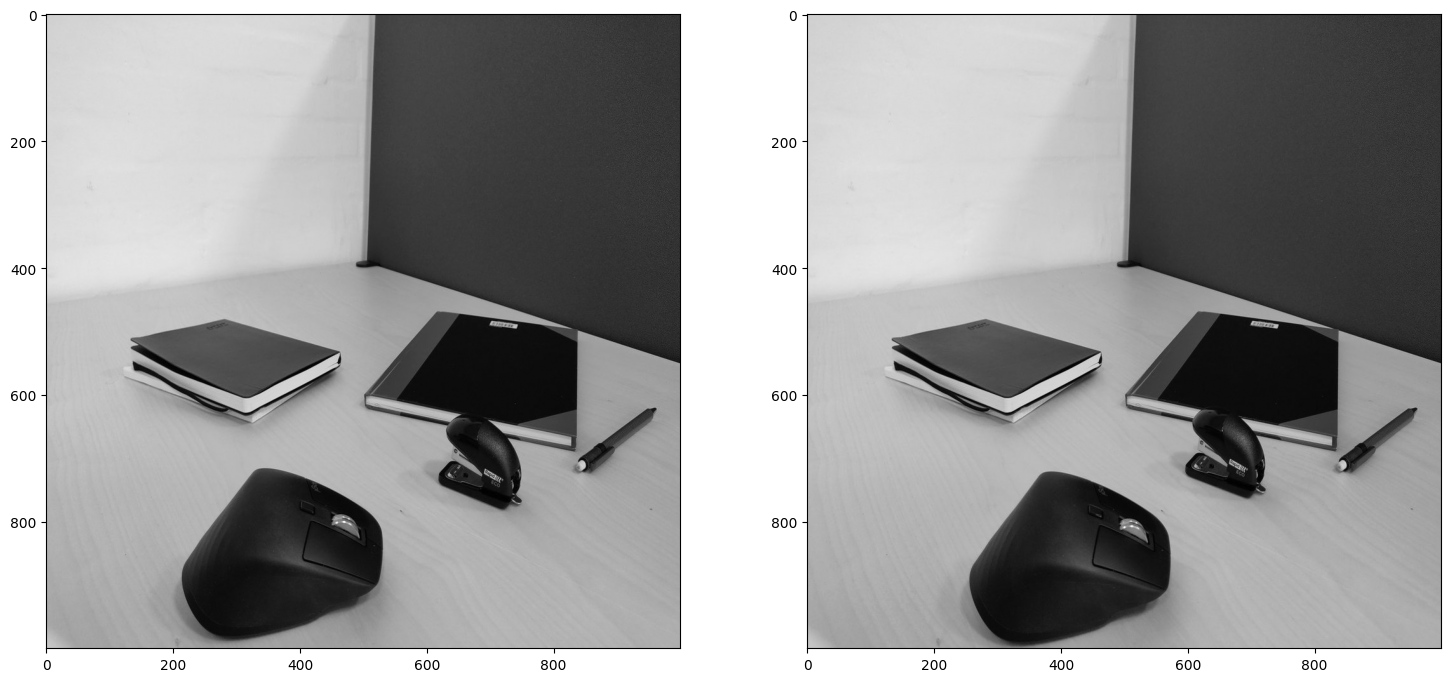

In [2]:
img1 = cv2.imread('OF1.jpg')
img2 = cv2.imread('OF2.jpg')

b,g,r = cv2.split(img1) # Changing the order from bgr to rgb so that matplotlib can show it
img1 = cv2.merge([r,g,b])
b,g,r = cv2.split(img2) # Changing the order from bgr to rgb so that matplotlib can show it
img2 = cv2.merge([r,g,b])

gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

img_org = img2.copy()

plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(gray1, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(gray2, cmap = 'gray')

They look pretty much the same. We can now use optical flow to find out how the objects in the picutures have moved. We do this by first using [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/4.7.0/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) to find features in the first image. You can play around with the parameters to see the difference.

In [3]:
feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)

Next we use the function [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/4.7.0/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323) to track the features in the next image.

In [4]:
feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)

We now have the location of the features from the first image in the second image. To find the movement, we can draw a line between the keypoints.

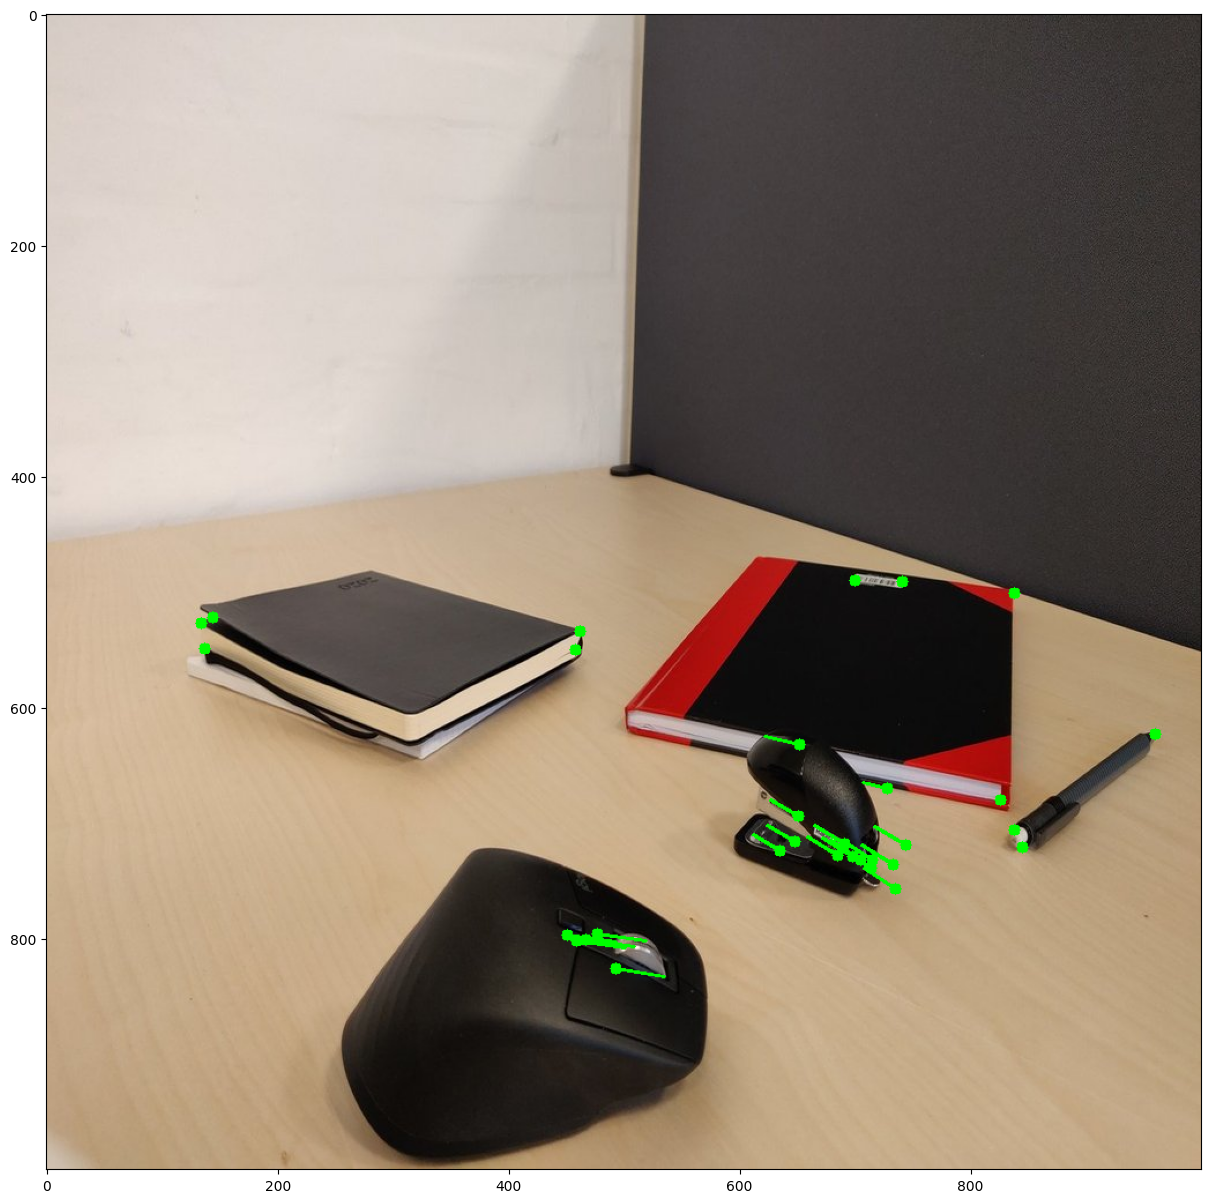

In [5]:
for i in range(len(feat1)):
    f10=int(feat1[i][0][0])
    f11=int(feat1[i][0][1])
    f20=int(feat2[i][0][0])
    f21=int(feat2[i][0][1])
    cv2.line(img2, (f10,f11), (f20, f21), (0, 255, 0), 2)
    cv2.circle(img2, (f10, f11), 5, (0, 255, 0), -1)

plt.figure(figsize=(15,15))
plt.imshow(img2)

## Exercise 4a
Change the code such that only the keypoints that have moved will be showed in the image.


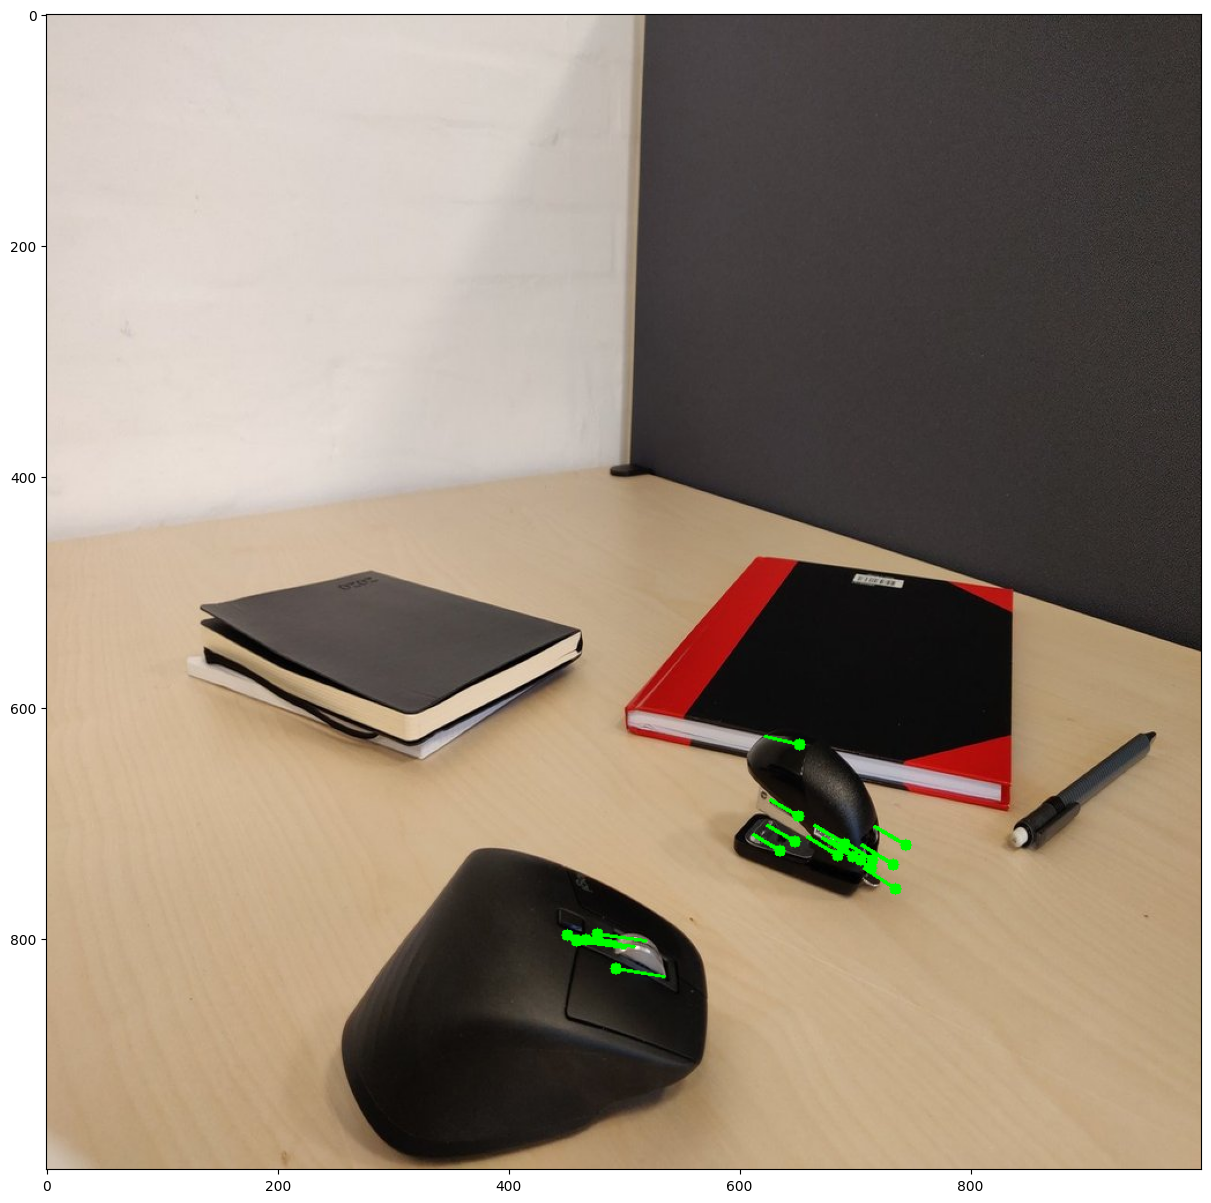

In [7]:
img = img_org.copy()

for i in range(len(feat1)):
    f10=int(feat1[i][0][0])
    f11=int(feat1[i][0][1])
    f20=int(feat2[i][0][0])
    f21=int(feat2[i][0][1])

    # Calculate the distance between the two points
    dist = np.sqrt((f10 - f20)**2 + (f11 - f21)**2)

    # Only draw the line if the distance is greater than 10
    if dist > 25.0:
        cv2.line(img, (f10,f11), (f20, f21), (0, 255, 0), 2)
        cv2.circle(img, (f10, f11), 5, (0, 255, 0), -1)

plt.figure(figsize=(15,15))
plt.imshow(img)

## Dense Optical Flow
The sparse optical flow finds the flow of the detected keypoints. We will now try to use dense optical flow which, finds the flow of all the points in the picture. 
For this example we use the same two images, so we don't have to load them again. To find the optical flow, we use the function [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/4.7.0/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Check out the description to see what all the different parameters do, and try to change them to see the difference.

In [8]:
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)

The function returns an array containing the flow vector for every pixel. This can be changed to a magnitude and an angle using the function [`cv2.cartToPolar`](https://docs.opencv.org/4.7.0/d2/de8/group__core__array.html#gac5f92f48ec32cacf5275969c33ee837d). 

# Exercise 4b
Find a way to represent the flow in the image, for example, by drawing vectors the relevant places or by making a new image with colors representing the flow of every pixel. An example of retrieving the magnitude and angle is shown below, which you can use if you like. 

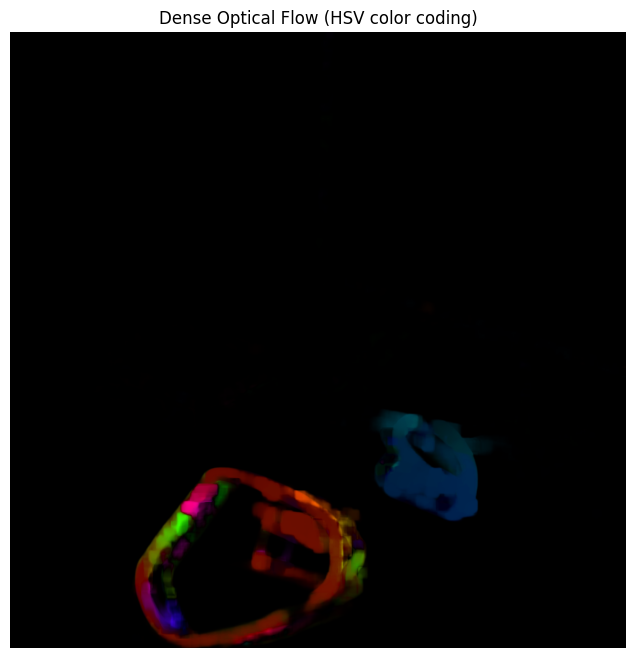

In [14]:
# Visualize dense optical flow using HSV color coding
mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Magnitude and angle of flow

# Create HSV image: hue = angle, value = normalized magnitude
hsv = np.zeros_like(img_org)
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
hsv[...,0] = ang * 180 / np.pi / 2  # Hue: direction of flow
hsv[...,1] = 255                    # Saturation: max
hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value: magnitude

flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(8,8))
plt.title("Dense Optical Flow (HSV color coding)")
plt.imshow(flow_rgb)
plt.axis('off')
plt.show()


In [ ]:
img = img_org.copy()
mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Magnitude and angle of flow

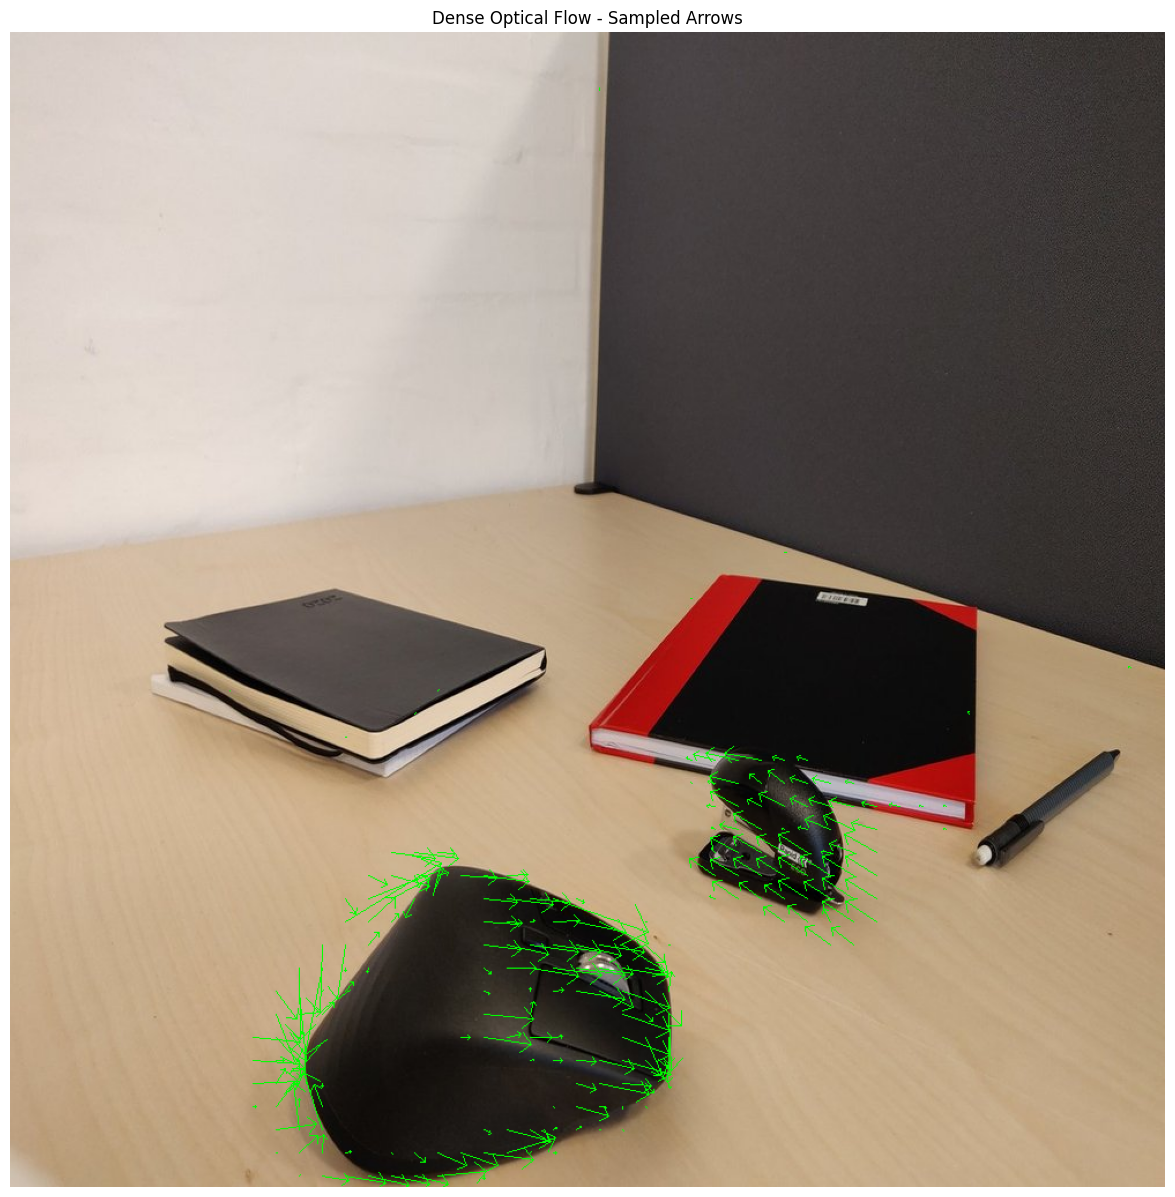

In [17]:
# Visualize dense optical flow using arrows (sampled)
img = img_org.copy()
mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Magnitude and angle of flow

# Sample the flow at regular intervals to avoid clutter
step = 20  # Sample every 20 pixels
h, w = flow.shape[:2]

# Create a grid of points to sample
y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)

# Draw arrows for sampled points
for i in range(len(x)):
    px, py = x[i], y[i]
    
    # Get flow vector at this point
    fx, fy = flow[py, px]
    
    # Only draw arrow if flow magnitude is significant
    if mag[py, px] > 1.0:  # Threshold to filter out small movements
        # Calculate end point of arrow
        end_x = int(px + fx)
        end_y = int(py + fy)
        
        # Draw arrow using cv2.arrowedLine
        cv2.arrowedLine(img, (px, py), (end_x, end_y), (0, 255, 0), 1, tipLength=0.3)

plt.figure(figsize=(15,15))
plt.title("Dense Optical Flow - Sampled Arrows")
plt.imshow(img)
plt.axis('off')
plt.show()
